In this notebook, I implement a few algorithms used in this [wonderful notebook by Morris B](https://www.kaggle.com/morrisb/how-to-recommend-anything-deep-recommender/data).The code has been changed to make it run using low memory (using sparse matrix etc)

[two content based recommendation approaches](https://towardsdatascience.com/introduction-to-two-approaches-of-content-based-recommendation-system-fc797460c18c)

[recommendar system general](https://github.com/youonf/recommendation_system)

lightfm, surprise, spotlight


In [ ]:
!pip install scikit-surprise -q

# Download Data From kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d netflix-inc/netflix-prize-data

 99% 676M/683M [00:04<00:00, 163MB/s]
100% 683M/683M [00:04<00:00, 159MB/s]


In [5]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

 93% 212M/228M [00:01<00:00, 149MB/s]
100% 228M/228M [00:01<00:00, 151MB/s]


In [6]:
!unzip -q ./netflix-prize-data.zip -d ./netflix

In [7]:
!unzip -q ./the-movies-dataset.zip -d ./movies

# import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
import surprise as surprise

# read data

We will use three data sources
1. movie_titles csv (id, year, title)
2. movies_metadata
3. ratings (userid, movieid, ratings(1-5)) we'll use only one file out of four

Unlike original notebook, we won't create pivot table representing user-item interactions matrix. Because its too big to fit in memory. 

In [3]:
def read_movie_titles():
  """
  file has few errors so cannot read directly
  """
  movie_titles = []
  with open('./netflix/movie_titles.csv', errors='ignore') as f:
    for line in f:
      parts = line.split(",")
      if len(parts) > 3:
        title = ", ".join(parts[2:])
      else:
        title = parts[2]
      title = title.rstrip("\n")
      year = np.nan if parts[1] == 'NULL' else parts[1]
      movie_titles.append({
          'Id': parts[0],
          'Year': year,
          'Title': title,
      })
  movie_titles = pd.DataFrame(movie_titles)
  movie_titles = movie_titles.dropna()
  movie_titles['Id'] = movie_titles['Id'].astype(int)
  movie_titles['Year'] = movie_titles['Year'].astype(int)
  movie_titles = movie_titles.set_index('Id')
  return movie_titles

In [4]:
movie_titles = read_movie_titles()

print(movie_titles.shape)
print(movie_titles.head())

(17763, 2)
    Year                         Title
Id                                    
1   2003               Dinosaur Planet
2   2004    Isle of Man TT 2004 Review
3   1997                     Character
4   1994  Paula Abdul's Get Up & Dance
5   2004      The Rise and Fall of ECW


In [5]:
# can be used for content based recommendation
movies_metadata = (pd.read_csv('./movies/movies_metadata.csv',
     low_memory=False)[['original_title', 'overview', 'vote_count']]
    .set_index('original_title')
    .dropna())

# remove long tail
movies_metadata = movies_metadata[movies_metadata['vote_count'] > 10].drop('vote_count', axis=1)

print(movies_metadata.shape)
print(movies_metadata.head())

(21604, 1)
                                                                      overview
original_title                                                                
Toy Story                    Led by Woody, Andy's toys live happily in his ...
Jumanji                      When siblings Judy and Peter discover an encha...
Grumpier Old Men             A family wedding reignites the ancient feud be...
Waiting to Exhale            Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II  Just when George Banks has recovered from his ...


In [6]:
def read_ratings(file_name):
  ratings = []

  with open(file_name) as f:
    movie_id = None
    for line in f:
      line = line.rstrip("\n")
      if re.fullmatch(r'\d+:', line) is not None:
        movie_id = int(line[:-1])
        continue
      parts = line.split(",")
      

      ratings.append([movie_id, 
                      int(parts[0]), 
                      float(parts[1]), 
                      parts[2]])

  ratings = pd.DataFrame(ratings, 
                      columns=['Movie', 'User', 'Rating', 'Date'])
  ratings['Date'] = pd.to_datetime(ratings['Date'], format='%Y-%m-%d')
  return ratings

In [7]:
ratings = read_ratings('./netflix/combined_data_1.txt')

# look at data

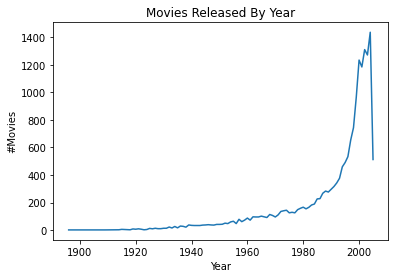

In [8]:
ax = (movie_titles['Year']
    .value_counts()
    .sort_index()
    .plot())

ax.set_title('Movies Released By Year')
ax.set_xlabel('Year')
ax.set_ylabel('#Movies');

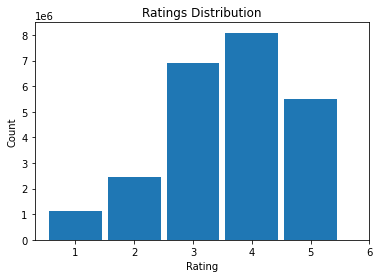

In [9]:
ax = ratings['Rating'].plot(kind='hist',
                       align='left', 
                       bins=[1, 2, 3, 4, 5, 6], 
                       rwidth=0.9)

ax.set_title('Ratings Distribution')
ax.set_ylabel("Count")
ax.set_xlabel("Rating")
ax.set_xticks([1, 2, 3, 4, 5, 6]);

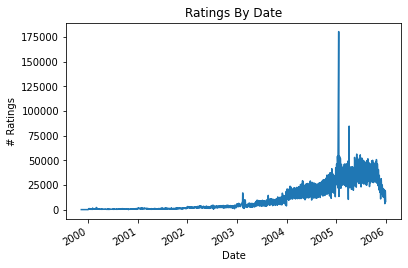

In [10]:
ax = ratings.groupby('Date').size().plot()

ax.set_title('Ratings By Date')
ax.set_ylabel('# Ratings');

In [11]:
print("First Rating Date", ratings['Date'].min())
print("Last Rating Date", ratings['Date'].max())

First Rating Date 1999-11-11 00:00:00
Last Rating Date 2005-12-31 00:00:00


In [12]:
# sparsity of original data
# this is incorrect since we are only considering 
# one rating file out of 4

num_movies = len(movie_titles)
num_users = ratings['User'].nunique()
num_ratings = len(ratings)
density = num_ratings / (num_movies * num_users)

print(f"movies  : {num_movies}")
print(f"users   : {num_users}")
print(f"ratings : {num_ratings}")
print(f"density : {density*100:0.5f}%")

movies  : 17763
users   : 470758
ratings : 24053764
density : 0.28765%


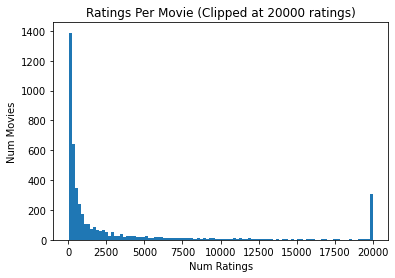

In [13]:
# movie, num ratings
# y = num movies
# x = num ratings
ax = (ratings
        .groupby('Movie').size().clip(upper=20000)
        .plot(kind='hist', bins=100))

ax.set_xlabel('Num Ratings')
ax.set_ylabel('Num Movies')
ax.set_title("Ratings Per Movie (Clipped at 20000 ratings)");

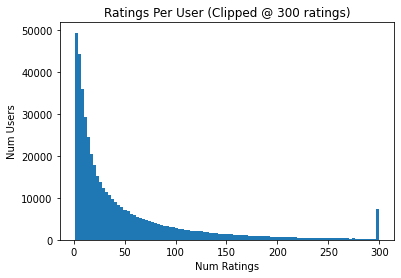

In [14]:
# user, num ratings
# y = num users
# x = num ratings
ax = (ratings
        .groupby('User').size().clip(upper=300)
        .plot(kind='hist', bins=100))

ax.set_xlabel('Num Ratings')
ax.set_ylabel('Num Users')
ax.set_title("Ratings Per User (Clipped @ 300 ratings)");

# discard sparse movies and sparse users

We'll be using collaborative filtering for most parts of this notebook. For collobaritve filtering to work we'll need to remove movies with too few interaction(ratings) and we'll remove users with too few interactions(ratings).

In [15]:
movie_ratings_count = ratings.groupby('Movie').size()
discard_movies = movie_ratings_count[(movie_ratings_count < 10000)]

user_ratings_count = ratings.groupby('User').size()
discard_users = user_ratings_count[(user_ratings_count < 200)]

ratings_filtered = ratings[~ratings['User'].isin(discard_users) & ~ratings['Movie'].isin(discard_movies)]

del discard_movies
del discard_users

In [16]:
# sparsity of original data
# this is incorrect since we are only considering 
# one rating file out of 4
num_movies = ratings_filtered['Movie'].nunique()
num_users = ratings_filtered['User'].nunique()
num_ratings = len(ratings_filtered)
density = num_ratings / (num_movies * num_users)

print(f"movies  : {num_movies}")
print(f"users   : {num_users}")
print(f"ratings : {num_ratings}")
print(f"density : {density*100:0.5f}%")

movies  : 2923
users   : 462632
ratings : 16095028
density : 1.19022%


# train test split

In [17]:
ratings_filtered = (ratings_filtered
                      .drop('Date', axis=1)
                      .sample(frac=1)
                      .reset_index(drop=True))

test_size = 100000

df_train = ratings_filtered[test_size:]
df_test = ratings_filtered[:test_size]

# mean model
* predicts rating = mean for each movie

In [25]:
avg_movie_rating = df_train.groupby('Movie')['Rating'].mean()
movie_rating_count = df_train.groupby('Movie').size()

In [26]:
# predict for test set
test_pred = pd.merge(df_test, avg_movie_rating, left_on='Movie', right_index=True)

# predicted values
test_predicted = test_pred['Rating_y']

# actual values
test_actual = test_pred['Rating_x']

# rmse of test set
test_rmse = mean_squared_error(test_actual, test_predicted, squared=False)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 1.017293434640161


In [27]:
temp = pd.merge(
    avg_movie_rating.sort_values(ascending=False)[:10].rename('movie_average_rating'),
    movie_rating_count.rename('movie_rating_count'),
    left_index=True,
    right_index=True
)


temp = pd.merge(
    temp,
    movie_titles[['Title']],
    left_index=True,
    right_index=True,
)

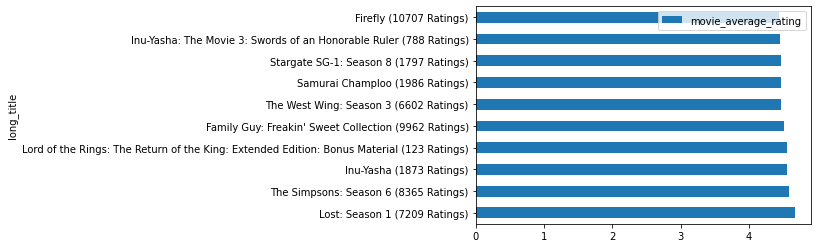

In [28]:
temp['long_title'] = temp['Title']  + ' (' + temp['movie_rating_count'].astype('string') + ' Ratings)'

temp.plot(kind='barh', 
          y='movie_average_rating', 
          x='long_title'
);

# weighted mean

weighted rating (WR)=(v/(v+m))R+(m/(v+m))C

where:
R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the top 50 (currently 1000)

C = the mean vote across the whole report (currently 6.8) 

```
Bayesian rating

Prior = average rating across dataset
W = weight few ratings 0 more ratings 1
(Prior * (1 - W)) + (W * Average For Movie)

W = v / (v + m)

```

https://math.stackexchange.com/questions/41459/how-can-i-calculate-most-popular-more-accurately/41513#41513

In [ ]:
R = df_train.groupby('Movie')['Rating'].mean()
v = df_train.groupby('Movie').size()
C = df_train['Rating'].mean()
m = 1000
W = v / (v + m)

In [ ]:
WR = (W * R) + ((1 - W) * C)

In [ ]:
WR = WR.sort_values(ascending=False)

In [ ]:
WR

Movie
3456    4.540607
2102    4.475256
3444    4.434182
3962    4.409562
2114    4.375698
          ...   
3573    2.508029
3567    2.491212
4255    2.489902
3505    2.485480
1100    2.445931
Length: 2923, dtype: float64

In [ ]:
test_pred = pd.merge(
    df_test,
    WR.rename('weighted_rating'),
    left_on='Movie',
    right_index=True
)

test_rmse = mean_squared_error(test_pred['Rating'], test_pred['weighted_rating'], squared=False)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 1.0214188258608077


# Cosine Similarity Between Users

* this approach is inefficient, in terms of both memory and computation
* fill gap in user_movie_matrix with mean for that movie

1. Find Similar Users Using cosine similarity of rows
2. Recommend High Rated Movies For Those Users


In [ ]:
# sort by user and movie
df_train_sorted = df_train.sort_values(['User', 'Movie'])

# movie_id, user_id
train_movie_ids = np.sort(df_train_sorted['Movie'].unique())
train_user_ids = np.sort(df_train_sorted['User'].unique())

# movie_id / user_id to index in cf_matrix
train_movie_id_to_idx = {movie_id: i for i, movie_id in enumerate(train_movie_ids)}
train_user_id_to_idx = {user_id: i for i, user_id in enumerate(train_user_ids)}

# Make Sparse Matrix
row = df_train_sorted['User'].map(train_user_id_to_idx).to_numpy()
col = df_train_sorted['Movie'].map(train_movie_id_to_idx).to_numpy()
train_cf_data = df_train_sorted['Rating'].to_numpy()

train_cf_data = coo_matrix(
    (train_cf_data, (row, col)), 
    shape=(len(train_user_ids), len(train_movie_ids))
)

In [ ]:
movie_avg_ratings = df_train.groupby('Movie')['Rating'].mean().sort_index()

In [ ]:
df_test

,Movie,User,Rating
0,2128,2596899,5.0
1,2763,1961026,4.0
2,2572,1611,3.0
3,3610,557847,5.0
4,3582,1386128,5.0
...,...,...,...
99995,2655,165720,4.0
99996,3860,508075,3.0
99997,3106,947177,4.0
99998,3890,1626661,3.0


In [ ]:
train_cf_data = train_cf_data.tocsr()

In [ ]:
def normalize_user_vector(vec):
  return np.where(vec == 0, movie_avg_ratings, vec)

def temp(user_id, top_users=10, top_recommendations=10):

  user_idx = train_user_id_to_idx[user_id]
  user_vec = train_cf_data[user_idx].toarray()[0]
  user_vec = normalize_user_vector(user_vec)

  similarities = []
  
  for other_user_id in train_user_ids:
  
    if other_user_id == user_id:
      similarities.append(-1.0)
      continue
  
    other_user_idx = train_user_id_to_idx[other_user_id]

    other_user_vec = train_cf_data[other_user_idx].toarray()[0]
    other_user_vec = normalize_user_vector(other_user_vec)

    # print(user_vec.shape, other_user_vec.shape)
    similarity = cosine_similarity([user_vec], [other_user_vec])
    similarities.append(similarity)

  similar_user_idxs = np.argsort(similarities)[-top_users:][::-1]
  similar_user_similarities = np.sort(similarities)[-top_users:][::-1]

  # print(similar_user_idxs.shape)
  # print(similar_user_similarities.shape)
    
  similar_user_vecs = np.array([
      train_cf_data[idx].toarray()[0]
      for i, idx in enumerate(similar_user_idxs)
  ])

  prediction = np.sum(similar_user_vecs, axis=0) / np.sum(similar_user_vecs == 0, axis=0)
  
  # print(prediction.shape)

  new_predictions = np.where(train_cf_data[user_idx].toarray()[0] == 0, prediction, -1)
  # print(new_predictions.shape)

  new_indices = np.argsort(new_predictions)[-top_recommendations:][::-1]
  new_ratings = np.sort(new_predictions)[-top_recommendations:][::-1]
  # print(new_indices.shape)
  # print(new_ratings.shape)
  new_movie_ids = [train_movie_ids[idx] for idx in new_indices]

  return new_movie_ids, new_ratings

In [ ]:
df_train

,Movie,User,Rating
100000,953,2626623,2.0
100001,3579,393038,3.0
100002,3326,775347,4.0
100003,2153,733409,3.0
100004,4402,2374247,5.0
...,...,...,...
16095023,1466,1559083,4.0
16095024,2953,1223456,3.0
16095025,2457,798465,3.0
16095026,1865,1262471,2.0


In [ ]:
new_movie_ids, new_ratings = temp(393038)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(10,)
(10,)
(2923,)
(2923,)
(10,)
(10,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
print("movies user likes")
pd.merge(
    df_train[df_train['User'] == 393038].sort_values('Rating', ascending=False)[:20],
    movie_titles,
    left_on='Movie',
    right_index=True
)

movies user likes


,Movie,User,Rating,Year,Title
15115166,2782,393038,5.0,1995,Braveheart
5933760,1180,393038,5.0,2001,A Beautiful Mind
15626649,4306,393038,5.0,1999,The Sixth Sense
12350382,1659,393038,5.0,1993,Grumpy Old Men
13901887,4123,393038,5.0,1998,Patch Adams
10010307,1615,393038,5.0,1995,The American President
6120738,2128,393038,5.0,1993,Rudy
2300015,3610,393038,5.0,1992,Lethal Weapon 3
12483888,4260,393038,5.0,2001,Rat Race
9422751,2612,393038,4.0,2001,Don't Say a Word


In [ ]:
print("movies user likes in test dataset")
pd.merge(
    df_test[df_test['User'] == 393038].sort_values('Rating', ascending=False)[:20],
    movie_titles,
    left_on='Movie',
    right_index=True
)

movies user likes in test dataset


,Movie,User,Rating,Year,Title
38760,985,393038,4.0,1999,The Mummy


In [ ]:
print("Movies Recommended")
movie_titles.loc[new_movie_ids]

Movies Recommended


,Year,Title
Id,,
1585,2001,Joy Ride
3826,1999,Music of the Heart
3923,1997,Beverly Hills Ninja
334,2005,The Pacifier
1719,2004,The Life Aquatic with Steve Zissou
1884,2001,Captain Corelli's Mandolin
4056,2001,Planet of the Apes
3414,1995,Pocahontas
2185,2002,Great North: IMAX


# Collobarative Filtering using matrix factorization

* we'll use surpise library which works for collobartive filtering with explicit ratings (ratings 1-5 star etc). Surpise lib does not work with implicit ratings(click, add_to_cart etc)
* using this library exactly the way its used in documentation makes work easier


In [18]:
reader = surprise.Reader(rating_scale=(1, 5))

dataset = surprise.Dataset.load_from_df(
    df=ratings_filtered[['User', 'Movie', 'Rating']],
    reader=reader
)

trainset, testset = surprise.model_selection.train_test_split(dataset,
                                          test_size=100000,
                                          random_state=42)

In [19]:
svd_mf = surprise.SVD(
    n_factors=64,   # dimension of latent space (user vector dimension and item vector dimension)
    n_epochs=20,    # gradient descent epochs
    reg_all=0.02,   # regularization
    random_state=42,
    verbose=True)

In [20]:
# fit
svd_mf.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [21]:
# evaluate on test set
results = svd_mf.test(testset)
surprise.accuracy.rmse(results)

RMSE: 0.9026


0.902565748384685

In [22]:
surprise.accuracy.mae(results)

MAE:  0.6977


0.6977045374980688

In [63]:
i = 0
for u in trainset.ur:
  u = trainset.to_raw_uid(u)
  print(u)
  i += 1
  if i >= 10:
    break

2625327
952554
18279
1814565
2584876
2323490
2618515
519130
2067044
640454


In [80]:
user_id = 2067044
predictions = []

for internal_movie_id in trainset.ir.keys():
    movie_id = trainset.to_raw_iid(internal_movie_id)
    predictions.append(svd_mf.predict(user_id, movie_id))

predictions = sorted(predictions, key=lambda a : -a.est)

print("Suggested movies")

for p in predictions[:20]:
  try:
    title = movie_titles.loc[p.iid]
    if len(title) > 0:
      print(title['Title'], ":", p.est)
  except:
    continue

Suggested movies
House of Cards Trilogy II: To Play the King : 5
House of Cards Trilogy I: House of Cards : 5
Gilmore Girls: Season 1 : 5
Stargate SG-1: Season 2 : 5
Stargate SG-1: Season 3 : 5
VeggieTales Classics: Rack,  Shack and Benny : 5
Smallville: Season 1 : 4.986481772052619
Pride and Prejudice : 4.985781188131291
Star Trek: The Next Generation: Season 5 : 4.951662729678411
Lost: Season 1 : 4.911931941829348
Buffy the Vampire Slayer: Season 6 : 4.906360933443213
Stargate SG-1: Season 8 : 4.90313834177062
Farscape: Season 2 : 4.870397165599936
Nero Wolfe: Season 2 : 4.8396243404922386
Star Trek: The Next Generation: Season 6 : 4.836930000379677
Angel: Season 4 : 4.830193643277918
The West Wing: Season 3 : 4.825530975118434
Little House on the Prairie: I'll Be Waving as You Drive Away : 4.789511338936697
The Rise and Fall of ECW : 4.78749651860485
Upstairs,  Downstairs: Season 3 : 4.782097654407605


In [81]:
trainset_ratings = None
for inner_uid, rs in trainset.ur.items():
  raw_uid = trainset.to_raw_uid(inner_uid)
  if raw_uid == user_id:
    trainset_ratings = [(trainset.to_raw_iid(r[0]), r[1]) for r in rs]
    break

trainset_ratings = sorted(trainset_ratings, key=lambda a : -a[1])

print("Rated Movies")

for p in trainset_ratings[:20]:
  try:
    title = movie_titles.loc[p[0]]
    if len(title) > 0:
      print(title['Title'], p[1])
  except:
    continue

Rated Movies
Do You Believe in Miracles? 5.0
Tick Tock 5.0
The Sixth Sense 5.0
Stargate SG-1: Season 2 5.0
My Tutor 5.0
Law & Order: Special Victims Unit: The First Year 5.0
Pete's Dragon 5.0
Star Trek: The Next Generation: Season 6 5.0
Doctor Zhivago 5.0
Stargate 5.0
Babylon 5: The River of Souls 5.0
The Winds of War 5.0
The Saint 5.0
VeggieTales Classics: Rack,  Shack and Benny 5.0
The Collector 5.0
101 Dalmatians II: Patch's London Adventure 5.0
War Games 5.0
Stargate SG-1: Season 3 5.0
Farscape: Season 2 5.0
Goldfinger 5.0


# light fm